# Exploring the nitty-gritty of map projections to harmonize MetPy/proj4 and GEMPAK

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.constants as mpconst
from metpy.units import units
import numpy as np
import pint
from pyproj import Proj
import xarray as xr

GEMPAK calculations will be read in from text files originating from gdlist, so use Kevin's functions for that purpose as well as to compare GEMPAK and MetPy results later. 

In [2]:
def read_nam_gdlist(name):
    file = open(name, 'rb')

    for _ in range(6):
        file.readline()

    grid_row = file.readline()
    nlon = int(grid_row[-11:-5].strip())
    nlat = int(grid_row[-4:].strip())
    #print(nlon,nlat)

    gempak_array = np.empty((nlat, nlon))

    for _ in range(2):
        file.readline()

    scale_row = file.readline()
    scale_factor = int(scale_row[19:].strip())
    #print(scale_factor)

    for _ in range(79):
        file.readline()

    col = 0
    row = 0
    
    for line in file.readlines():
        if (line[:8].strip() != b'') & (col >= nlon):
            col = 0
            row+=1
        for count in [0,1,2,3,4,5,6,7]:
            if (line[8+count*9:17+count*9]) == '\n':
                gempak_array[row, col] = np.nan
            else:
                gempak_array[row, col] = line[8+count*9:17+count*9]
            col+=1
            if col >= nlon: break

    file.close()
    
    return (gempak_array, -scale_factor)

def error_stats(metpy_data, gempak_data):
    ignore = (gempak_data != -9999.0) * ~np.isnan(metpy_data)
    
    if isinstance(metpy_data.data, pint.Quantity):
        print(f'Is Xarray with Quantity? True')
        mdata = metpy_data.values[ignore]
    elif isinstance(metpy_data, pint.Quantity):
        print(f'Is Xarray with Quantity? False')
        print(f'Is Metpy Unit Array? True')
        mdata = metpy_data.m[ignore]
    else:
        print(f'Is Xarray with Quantity? False')
        print(f'Is Metpy Unit Array? False')
        print(f'I got back just a numpy array')
        try:
            mdata = metpy_data.values[ignore]
        except:
            mdata = metpy_data[ignore]
    gempak_data = gempak_data[ignore]
    
    print()
    print('Mean Comparison')
    print(f'  Mean Values (MetPy): {mdata.mean()}')
    print(f'  Mean Values (GEMPAK): {gempak_data.mean()}')
    print()
    print('Max Comparison')
    print(f'  Max Values (MetPy): {mdata.max()}')
    print(f'  Max Values (GEMPAK): {gempak_data.max()}')
    print()
    print('Min Comparison')
    print(f'  Min Values (MetPy): {mdata.min()}')
    print(f'  Min Values (GEMPAK): {gempak_data.min()}')

    print()
    print('Difference Array')
    diff = mdata - gempak_data
    print(diff)
    print()
    print('Various Statistical Analyses')
    print(f'  Average Absolute Difference: {np.nanmean(np.abs(diff))}')
    print(f'  RMS Error: {np.sqrt(np.nansum(diff**2))/len(diff.ravel())}')
    print(f'  Standard Deviation of Difference: {np.nanstd(diff)}')
    print(f'  Max Diff: {np.max(diff)}')
    print(f'  Min Diff: {np.min(diff)}')
    print(f'  Correlation: {np.corrcoef(mdata.ravel(), gempak_data.ravel())[0][1]}')
    print(f'  Relative Magnitude Difference: {np.nanmean(np.abs(diff))/np.nanmax(mdata)}')
    print()
    
def extract_gemdata(out_var, scale):
    return out_var[::-1, :] * 10**scale

## Case 1: Grid 218 (LCC)

### Map factor comparison

#### GEMPAK

The crux of the problem seems to be that GEMPAK's definition of "map factor" differs from proj4's, as they give different results when used in trial calculations. Let's verify this. First, here are the map factors from GEMPAK. (Note that this is a conformal grid, so the map factors at a given gridpoint should be the same in both x and y directions, but we check both to be complete.)

In [3]:
msfx_gem = extract_gemdata(*read_nam_gdlist('msfx218.txt'))
lat_gem = np.rad2deg(extract_gemdata(*read_nam_gdlist('latr218.txt')))
lon_gem = np.rad2deg(extract_gemdata(*read_nam_gdlist('lonr218.txt')))

/home/decker/local/miniconda3/envs/metpy21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


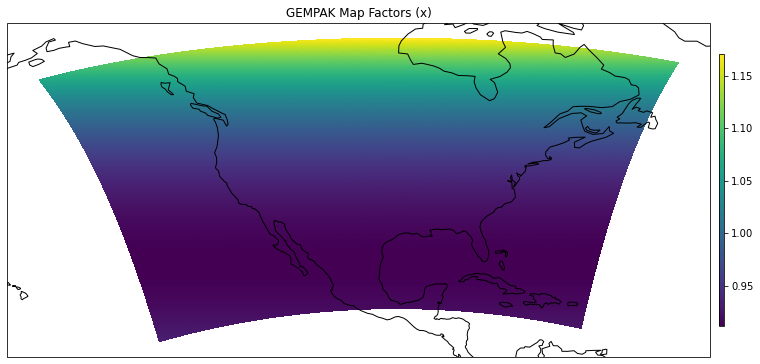

In [4]:
map_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": map_proj})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_gem, shading='auto')
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('GEMPAK Map Factors (x)')
plt.show()

In [5]:
# Verify y factors are the same
msfy_gem = extract_gemdata(*read_nam_gdlist('msfy218.txt'))
print('x and y factors are same?', np.all(msfx_gem == msfy_gem))

x and y factors are same? True


Grid 218 is an LCC projection with standard parallel 25 N and standard longitude 95 W. The map above shows that the map factors for this projection are a function of latitude only, which is in agreement with the underlying theory. Somewhat surprising (to me) is the next plot, which shows that, while the standard latitude is where the map factor is minimized, that minimum is not 1.

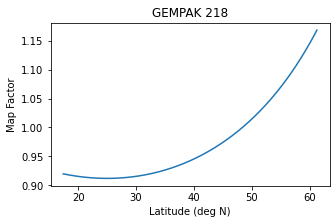

In [6]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,300],msfx_gem[:,300])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('GEMPAK 218')
plt.show()

Now let's see what proj4 produces. To get as close to GEMPAK as possible, we assume a spherical Earth with the radius as used by GEMPAK, then set up the corresponding Cartopy projection.

In [7]:
earth_radius = 6371200
earth_sphere = ccrs.Globe(ellipse=None, semimajor_axis=earth_radius)

In [8]:
lcc_proj = ccrs.LambertConformal(globe=earth_sphere, 
                                 standard_parallels=(25,25),
                                 central_longitude=-95, central_latitude=25)

One issue: GEMPAK does not state a central latitude. The proj4 parameters in Kevin's notebook give 25N for that as well, so we included that above.

Let's see if the GEMPAK data is rectangular on this projection.

/home/decker/local/miniconda3/envs/metpy21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


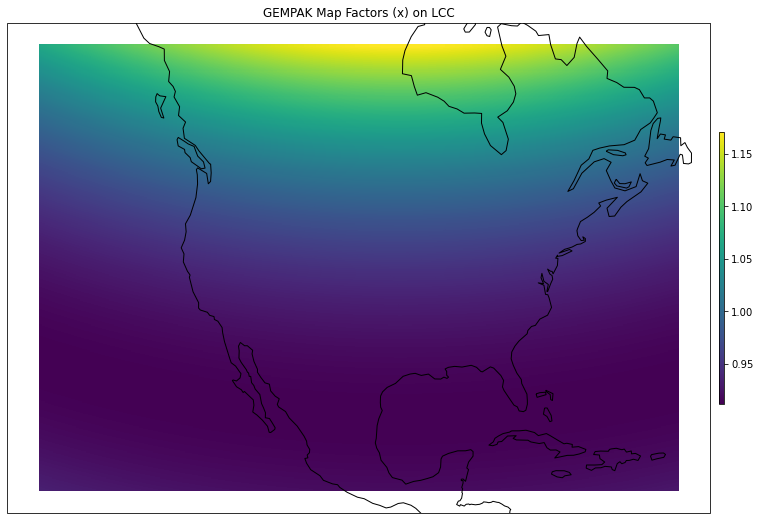

In [9]:
fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": lcc_proj})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_gem, shading='auto', transform=map_proj)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('GEMPAK Map Factors (x) on LCC')
plt.show()

Looks good, but what do the proj4 map factors look like?

#### proj4

In [10]:
lcc_proj.proj4_params

{'a': 6371200,
 'proj': 'lcc',
 'lon_0': -95,
 'lat_0': 25,
 'x_0': 0.0,
 'y_0': 0.0,
 'lat_1': 25,
 'lat_2': 25}

In [11]:
factors = Proj(projparams=lcc_proj.proj4_params).get_factors(lon_gem, lat_gem)

In [12]:
msfx_p4 = factors.parallel_scale
msfy_p4 = factors.meridional_scale
print('proj4 x and y factors the same?', np.all(msfx_p4 == msfy_p4))

proj4 x and y factors the same? False


In [13]:
error_stats(msfx_p4, msfy_p4)

Is Xarray with Quantity? False
Is Metpy Unit Array? False
I got back just a numpy array

Mean Comparison
  Mean Values (MetPy): 1.064650454406276
  Mean Values (GEMPAK): 1.0646504544396156

Max Comparison
  Max Values (MetPy): 1.2836348932152322
  Max Values (GEMPAK): 1.283634893356647

Min Comparison
  Min Values (MetPy): 0.9999999999943233
  Min Values (GEMPAK): 1.000000000002675

Difference Array
[-2.70137246e-11  1.34872113e-11  3.81250587e-13 ... -9.70243885e-11
 -7.36168904e-11 -5.97910610e-11]

Various Statistical Analyses
  Average Absolute Difference: 3.514540758898182e-11
  RMS Error: 8.687414804690403e-14
  Standard Deviation of Difference: 2.952624603627866e-11
  Max Diff: 5.146705284175823e-11
  Min Diff: -1.4952550309033086e-10
  Correlation: 1.0
  Relative Magnitude Difference: 2.7379598182276002e-11



OK, the proj4 factors only differ in the 10th decimal place at most; this is likely round-off error. (Presumably GEMPAK uses theory to make its x and y factors identical.) We will stick to the x-factors only for further comparisons. Here's the plots:

/home/decker/local/miniconda3/envs/metpy21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


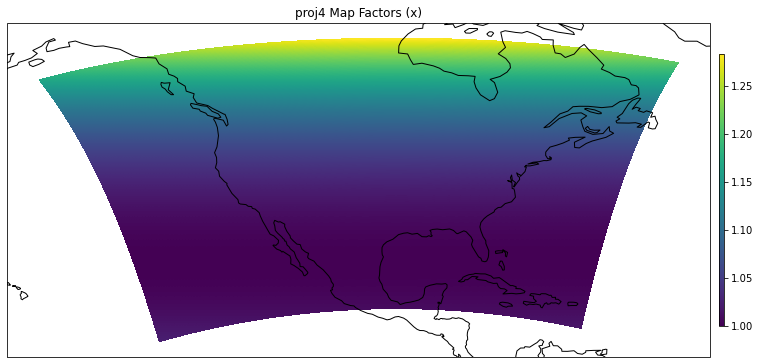

In [14]:
fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": map_proj})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_p4, shading='auto')
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('proj4 Map Factors (x)')
plt.show()

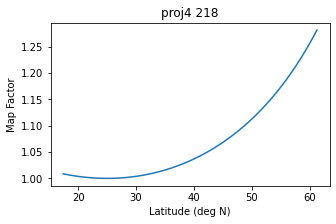

In [15]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,300],msfx_p4[:,300])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('proj4 218')
plt.show()

So the shape is the same, but the values are different. What is the relationship between the two?

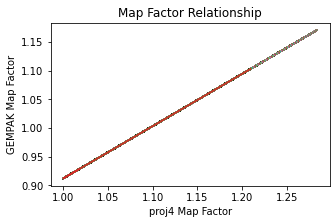

In [16]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(msfx_p4, msfx_gem)
ax.set_ylabel('GEMPAK Map Factor')
ax.set_xlabel('proj4 Map Factor')
plt.title('Map Factor Relationship')
plt.show()

Looks like a linear scaling, which makes sense if the nominal scale is the key. If this linear relationship passes through the origin, the ratio should be constant. Let's check.

In [17]:
ratio = msfx_p4 / msfx_gem
print(ratio.max())
print(ratio.min())
print(ratio.mean())

1.0965542167058344
1.096552172520864
1.0965532132005624


So we see that dividing the proj4 map factors by ~1.096553 reproduces the GEMPAK scale factors (for Grid 218). Thus, the nominal scales in the two systems differ by this ratio. But where does this ratio come from?

The 218 grid is considered a 12-km grid; do either of the nominal scales equate to 12 km per gridpoint? Furthermore, https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID218 indicates the grid is constructed such that the real distance between gridpoints is 12 km at 35 N, so we can use this as a point of comparison.

In [18]:
i12 = 160; j12 = 347
lat_gem[i12,j12], lon_gem[i12,j12]

(35.000559310054165, -94.95457651364595)

In [19]:
lons = (lon_gem[i12-1,j12], lon_gem[i12+1,j12])
lats = (lat_gem[i12-1,j12], lat_gem[i12+1,j12])

In [20]:
p4 = Proj(projparams=lcc_proj.proj4_params)
geod = p4.crs.get_geod()
grid_distance = geod.line_length(lons, lats) / 2

In [21]:
print(grid_distance)

12000.155199999606


This is very close to 12 km, so we seem to be on the right track. Multiplying this length by the map factor should give the nominal scale for each map.

In [22]:
nominal_scale_gem = grid_distance * msfx_gem[i12,j12]
nominal_scale_p4 = grid_distance * msfx_p4[i12,j12]
print(nominal_scale_gem)
print(nominal_scale_p4)

11117.339782401235
12190.758028164626


With this info, we should be able to reproduce the GEMPAK vorticity calculation to very high accuracy:

In [23]:
u = extract_gemdata(*read_nam_gdlist('urel218.txt'))
v = extract_gemdata(*read_nam_gdlist('vrel218.txt'))

dx = nominal_scale_gem
dy = nominal_scale_gem
m_x = msfx_gem
m_y = msfy_gem

dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)

# Calculating Vorticity using Map Factors
zeta = (m_x * dvdx - m_y * dudy
        - v * (m_x/m_y) * mpcalc.first_derivative(m_y, delta=dx, axis=-1)
        + u * (m_y/m_x) * mpcalc.first_derivative(m_x, delta=dy, axis=-2))

In [24]:
vor_gem = extract_gemdata(*read_nam_gdlist('vor218.txt'))
error_stats(zeta[3:-3,3:-3]*1e5, vor_gem[3:-3,3:-3]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): -0.07599650550839102
  Mean Values (GEMPAK): -0.07599521389373916

Max Comparison
  Max Values (MetPy): 170.67000471224065
  Max Values (GEMPAK): 170.6667

Min Comparison
  Min Values (MetPy): -91.94957129116437
  Min Values (GEMPAK): -91.9478

Difference Array
[ 3.09274539e-04  5.59205425e-04  8.51759948e-04 ... -7.13164998e-05
 -5.17308852e-05 -9.96161556e-05]

Various Statistical Analyses
  Average Absolute Difference: 8.933159818994715e-05
  RMS Error: 2.6376687246708607e-07
  Standard Deviation of Difference: 0.0001336004651530771
  Max Diff: 0.0033113286521881946
  Min Diff: -0.0017869406818959988
  Correlation: 0.9999999999869911
  Relative Magnitude Difference: 5.234170957021142e-07



We should get equally good agreement with the proj4 map factors as long as we use the proj4 nominal scale.

In [25]:
dx = nominal_scale_p4
dy = nominal_scale_p4
m_x = msfx_p4
m_y = msfy_p4

dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)

# Calculating Vorticity using Map Factors
zeta = (m_x * dvdx - m_y * dudy
        - v * (m_x/m_y) * mpcalc.first_derivative(m_y, delta=dx, axis=-1)
        + u * (m_y/m_x) * mpcalc.first_derivative(m_x, delta=dy, axis=-2))

error_stats(zeta[3:-3,3:-3]*1e5, vor_gem[3:-3,3:-3]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): -0.07599648822269235
  Mean Values (GEMPAK): -0.07599521389373916

Max Comparison
  Max Values (MetPy): 170.6700525392594
  Max Values (GEMPAK): 170.6667

Min Comparison
  Min Values (MetPy): -91.94960424439128
  Min Values (GEMPAK): -91.9478

Difference Array
[ 2.91526712e-04  5.49010884e-04  8.62249220e-04 ... -5.88349022e-05
 -6.57130873e-05 -9.98617855e-05]

Various Statistical Analyses
  Average Absolute Difference: 8.734937039150812e-05
  RMS Error: 2.588105464116817e-07
  Standard Deviation of Difference: 0.00013108997048815905
  Max Diff: 0.003352539259395826
  Min Diff: -0.0018042443912804629
  Correlation: 0.9999999999893863
  Relative Magnitude Difference: 5.118025634369279e-07



So we can indeed match GEMPAK's vorticity if we use the proper constant for dx (= dy). Let's compare this to the value of dx in Kevin's calculation:

In [26]:
nam_data = xr.open_dataset('namanl_218_20180308_0000_000.nc').metpy.parse_cf()
nam_data = nam_data.metpy.assign_latitude_longitude()

data_var_u = nam_data['u-component_of_wind_isobaric'].metpy.sel(time=datetime(2018, 3, 8, 0),
                                                                vertical=500*units.hPa).metpy.quantify()

dx_grid = (data_var_u.x[1].values - data_var_u.x[0].values) * units.meters
print(dx_grid)

12191.0 meter


In [61]:
#nam_data

This is only 3 meters off from what was used above, a discrepancy that is probably due to a different radius of the Earth (and/or sphere vs. spheroid). For completeness, let's try this value and compare to GEMPAK:

In [28]:
dx = dx_grid
dy = dx_grid
m_x = msfx_p4
m_y = msfy_p4

dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)

# Calculating Vorticity using Map Factors
zeta = (m_x * dvdx - m_y * dudy
        - v * (m_x/m_y) * mpcalc.first_derivative(m_y, delta=dx, axis=-1)
        + u * (m_y/m_x) * mpcalc.first_derivative(m_x, delta=dy, axis=-2))

error_stats(zeta[3:-3,3:-3]*1e5, vor_gem[3:-3,3:-3]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): -0.07599497981405189
  Mean Values (GEMPAK): -0.07599521389373916

Max Comparison
  Max Values (MetPy): 170.66666501191492
  Max Values (GEMPAK): 170.6667

Min Comparison
  Min Values (MetPy): -91.94777919193449
  Min Values (GEMPAK): -91.9478

Difference Array
[-5.00025406e-05  1.02151890e-05 -4.03242298e-05 ...  9.73851536e-06
  1.76435545e-05 -8.58495454e-06]

Various Statistical Analyses
  Average Absolute Difference: 2.5594156931033214e-05
  RMS Error: 5.9038904322475143e-08
  Standard Deviation of Difference: 2.9904255835282108e-05
  Max Diff: 0.00011743228295424402
  Min Diff: -0.00010770835442031057
  Correlation: 0.9999999999893869
  Relative Magnitude Difference: 1.4996576472181247e-07



This is actually even closer, so now I am not sure why Kevin's calculation didn't work. The last thing to check is that not including the map factors degrades the calculation:

In [29]:
dx = dx_grid
dy = dx_grid
m_x = msfx_p4
m_y = msfy_p4

dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)

# Calculating Vorticity w/o Map Factors
zeta = dvdx - dudy

error_stats(zeta[3:-3,3:-3]*1e5, vor_gem[3:-3,3:-3]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): -0.11720032242686507
  Mean Values (GEMPAK): -0.07599521389373916

Max Comparison
  Max Values (MetPy): 159.66696743499304
  Max Values (GEMPAK): 170.6667

Min Comparison
  Min Values (MetPy): -88.22081863669922
  Min Values (GEMPAK): -91.9478

Difference Array
[-0.3909163  -0.60903084 -1.01347285 ...  0.50180189  0.63139395
  0.70228304]

Various Statistical Analyses
  Average Absolute Difference: 0.27676897590771105
  RMS Error: 0.0011552964025638164
  Standard Deviation of Difference: 0.5837436380584016
  Max Diff: 10.3537401443688
  Min Diff: -12.424127905832165
  Correlation: 0.9980146799427708
  Relative Magnitude Difference: 0.0017334141203652223



This calculation is indeed degraded. So the mystery of Grid 218 (LCC) is solved, but global GFS (CED) and stereographic should still be (re)visited.

## Case 2: Stereographic (Grid 104)

### Comparison of GEMPAK map factors with proj4

This grid is "N. Hemisphere Polar Stereographic grid oriented 105W" with a grid spacing of "90.75464 km at 60N". Let's create the corresponding Cartopy projection.

In [30]:
grid104 = ccrs.NorthPolarStereo(globe=earth_sphere, central_longitude=-105)
grid104

In [31]:
def read_nam_104(name):
    file = open(name, 'rb')

    for _ in range(6):
        file.readline()

    grid_row = file.readline()
    nlon = int(grid_row[-11:-5].strip())
    nlat = int(grid_row[-4:].strip())

    gempak_array = np.empty((nlat, nlon))

    for _ in range(2):
        file.readline()

    scale_row = file.readline()
    scale_factor = int(scale_row[19:].strip())

    for _ in range(21):
        file.readline()

    col = 0
    row = 0
    
    for line in file.readlines():
        #print(line)
        if (line[:8].strip() != b'') & (col >= nlon):
            col = 0
            row+=1
        for count in [0,1,2,3,4,5,6,7]:
            val = line[8+count*9:17+count*9]
            #print(val)
            if val == b'\n':
                col = 0
                row += 1
                break
            else:
                gempak_array[row, col] = val
            col+=1
            if col >= nlon: break

    file.close()
    
    return (gempak_array, -scale_factor)

In [32]:
msfx_gem = extract_gemdata(*read_nam_104('msfx104.txt'))
lat_gem = np.rad2deg(extract_gemdata(*read_nam_104('latr104.txt')))
lon_gem = np.rad2deg(extract_gemdata(*read_nam_104('lonr104.txt')))

/home/decker/local/miniconda3/envs/metpy21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


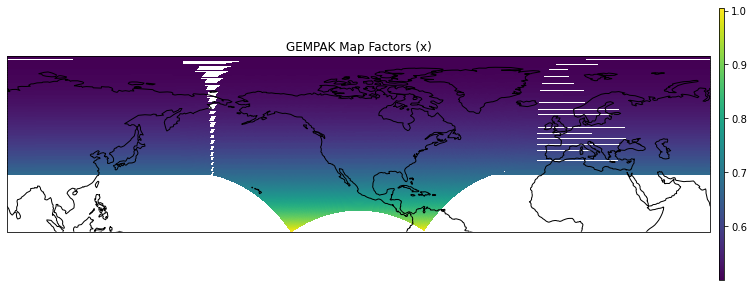

In [33]:
map_proj = ccrs.PlateCarree(central_longitude=-105)

fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": map_proj})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_gem, transform=ccrs.PlateCarree())
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('GEMPAK Map Factors (x)')
plt.show()

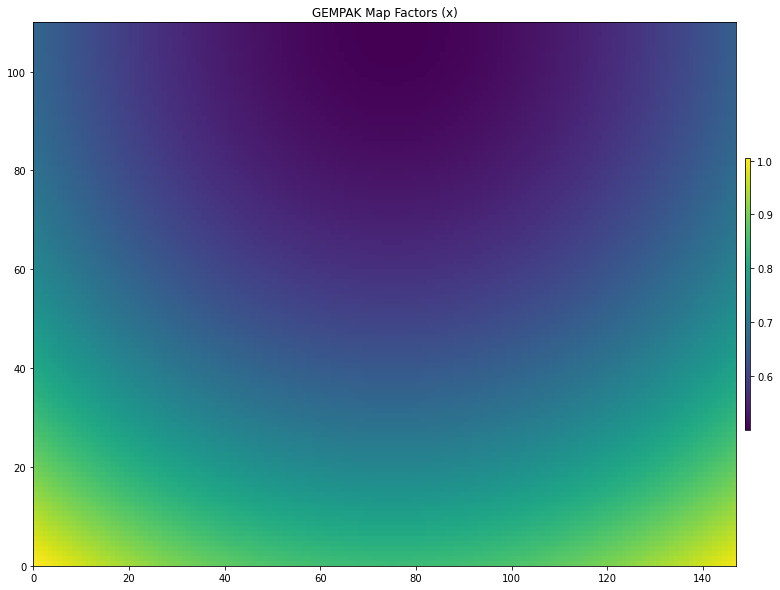

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(msfx_gem)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('GEMPAK Map Factors (x)')
plt.show()

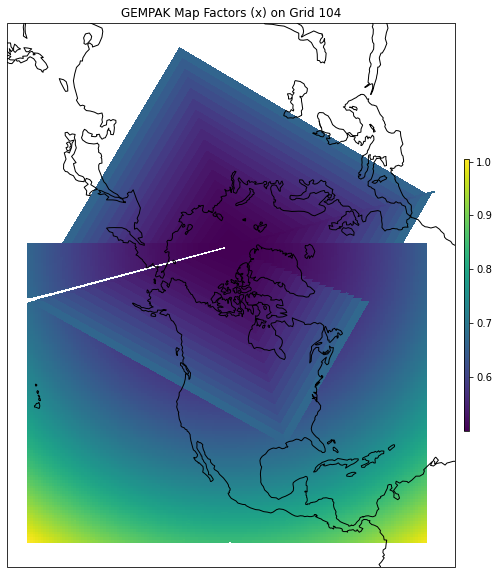

In [35]:
fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": grid104})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_gem, shading='auto',
                   transform=ccrs.PlateCarree())
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('GEMPAK Map Factors (x) on Grid 104')
plt.show()

Hmm, there seem to be bugs galore here, but whether it is in my code, Cartopy, or matplotlib, I cannot say. Let's press on, anyway!

#### proj4

In [36]:
grid104.proj4_params

{'a': 6371200,
 'proj': 'stere',
 'lat_0': 90,
 'lon_0': -105,
 'x_0': 0.0,
 'y_0': 0.0}

In [37]:
factors = Proj(projparams=lcc_proj.proj4_params).get_factors(lon_gem, lat_gem)
msfx_p4 = factors.parallel_scale
msfy_p4 = factors.meridional_scale
print('proj4 x and y factors the same?', np.all(msfx_p4 == msfy_p4))
error_stats(msfx_p4, msfy_p4)

proj4 x and y factors the same? False
Is Xarray with Quantity? False
Is Metpy Unit Array? False
I got back just a numpy array

Mean Comparison
  Mean Values (MetPy): 1.127828313480794
  Mean Values (GEMPAK): 1.1278283144961971

Max Comparison
  Max Values (MetPy): 11.19371335605445
  Max Values (GEMPAK): 11.1937159976915

Min Comparison
  Min Values (MetPy): 1.0000000040646237
  Min Values (GEMPAK): 1.000000004080439

Difference Array
[-8.83626505e-12  2.36966002e-12  5.59707836e-12 ... -3.82578413e-11
 -3.86730648e-11 -4.93429742e-11]

Various Statistical Analyses
  Average Absolute Difference: 1.0182713740299147e-09
  RMS Error: 3.294719487904258e-10
  Standard Deviation of Difference: 4.188377964293349e-08
  Max Diff: 5.129097147005268e-11
  Min Diff: -2.641637049549672e-06
  Correlation: 0.9999999999999949
  Relative Magnitude Difference: 9.096814807028737e-11



Again, theoretically the x and y scale factors should be identical, but minor roundoff error is occurring in proj4.  However, we can already tell the values are substantially different from GEMPAK's.  Presumably the nominal scale is again what is different.

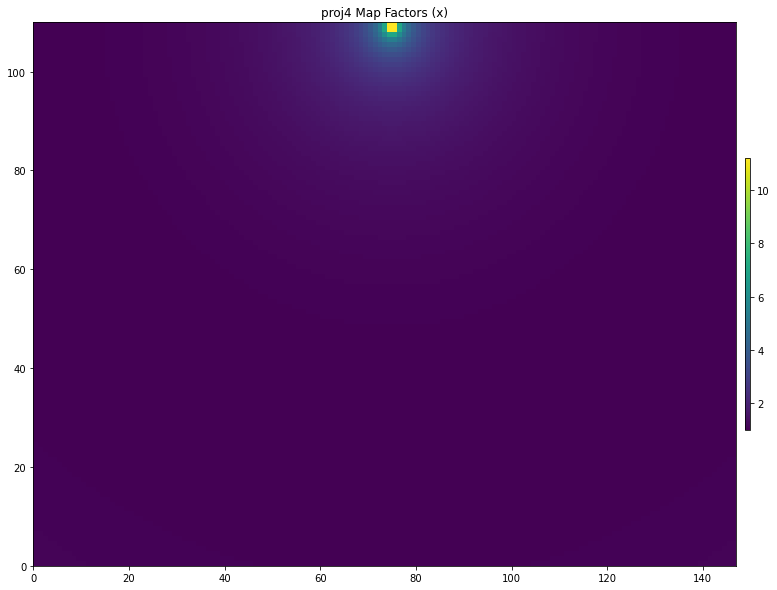

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(msfx_p4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('proj4 Map Factors (x)')
plt.show()

We seem to have a reciprocal relationship. Let's plot the reciprocal of the proj4 factors.

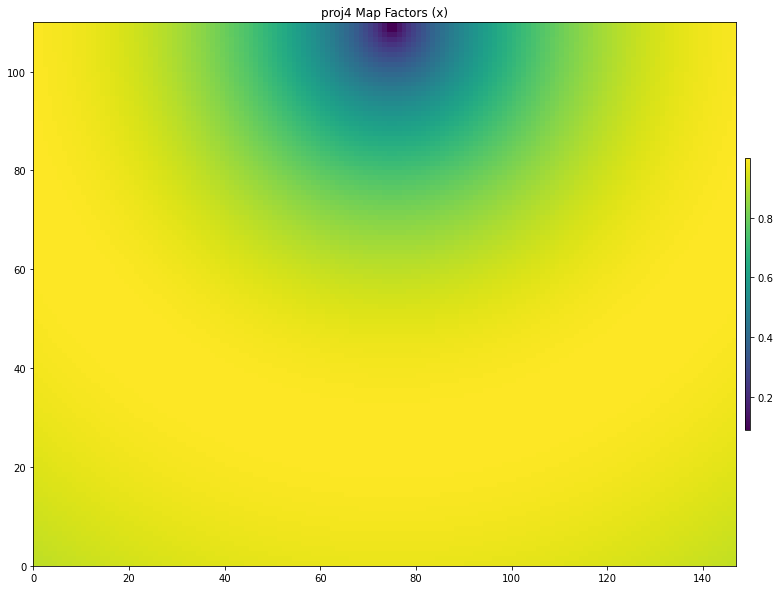

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(1/msfx_p4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('proj4 Map Factors (x)')
plt.show()

Hmm, agreement is hard to come by here. Let's simplify by looking along the central meridian (or close to it).

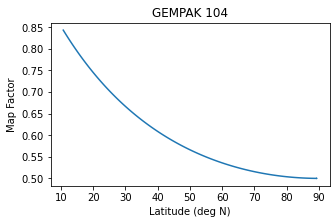

In [40]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,75],msfx_gem[:,75])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('GEMPAK 104')
plt.show()

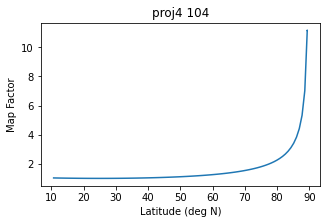

In [41]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,75],msfx_p4[:,75])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('proj4 104')
plt.show()

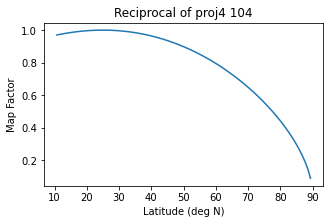

In [42]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,75],1/msfx_p4[:,75])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('Reciprocal of proj4 104')
plt.show()

Not sure what's going on, but GEMPAK's map factors make more sense to me (extrema at the highest and lowest latitude). The minimum in the proj4 scale factors (maximum in reciprocal) around 25 N doesn't make sense to me.  This suggests I might have computed them improperly, or created the projection incorrectly, so I should also try reading a netCDF file on this grid and see what the various metpy/xarray "magic" does with it. 

In [43]:
vor_gem = extract_gemdata(*read_nam_104('vor104.txt'))

### Compute vorticity w/o map factors

First, we'll determine GEMPAK's nominal scale. We are told grid spacing is 90.75464 km at 60 N.

In [44]:
i = 73; j = 75
lat_gem[i,j], lon_gem[i,j]

(59.67309599663914, -104.19180208674507)

In [45]:
lons = (lon_gem[i,j], lon_gem[i+1,j])
lats = (lat_gem[i,j], lat_gem[i+1,j])

In [46]:
p4 = Proj(projparams=lcc_proj.proj4_params)
geod = p4.crs.get_geod()
grid_distance = geod.line_length(lons, lats)

In [47]:
print(grid_distance)

90786.20544082196


In [48]:
nominal_scale_gem = grid_distance * msfx_gem[i,j]
nominal_scale_p4 = grid_distance * msfx_p4[i,j]
print(nominal_scale_gem)
print(nominal_scale_p4)

48727.04454281428
113549.30898537544


In [49]:
u = extract_gemdata(*read_nam_104('urel104.txt'))
v = extract_gemdata(*read_nam_104('vrel104.txt'))

#dx = nominal_scale_gem
#dy = nominal_scale_gem
dx = 90755 * units.m
dy = dx
#m_x = msfx_gem
#m_y = msfy_gem

dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)

# Calculating Vorticity using Map Factors
zeta = dvdx - dudy
#zeta = (m_x * dvdx - m_y * dudy
#        - v * (m_x/m_y) * mpcalc.first_derivative(m_y, delta=dx, axis=-1)
#        + u * (m_y/m_x) * mpcalc.first_derivative(m_x, delta=dy, axis=-2))

# Weird stuff happens in upper corners, so look even further from boundaries
error_stats(zeta[6:-6,6:-6]*1e5, vor_gem[6:-6,6:-6]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): -0.03927662679246612
  Mean Values (GEMPAK): -0.08189264550264547

Max Comparison
  Max Values (MetPy): 23.982149743815768
  Max Values (GEMPAK): 30.137600000000003

Min Comparison
  Min Values (MetPy): -12.026885571042918
  Min Values (GEMPAK): -16.888099999999998

Difference Array
[-0.85802572 -0.97785491 -1.2004413  ... -0.37923238 -0.17061094
  0.01223074]

Various Statistical Analyses
  Average Absolute Difference: 0.36904268784626226
  RMS Error: 0.005424988578729979
  Standard Deviation of Difference: 0.6225346610664371
  Max Diff: 6.227530334416835
  Min Diff: -9.587768034819021
  Correlation: 0.9887886349923245
  Relative Magnitude Difference: 0.015388223815983244



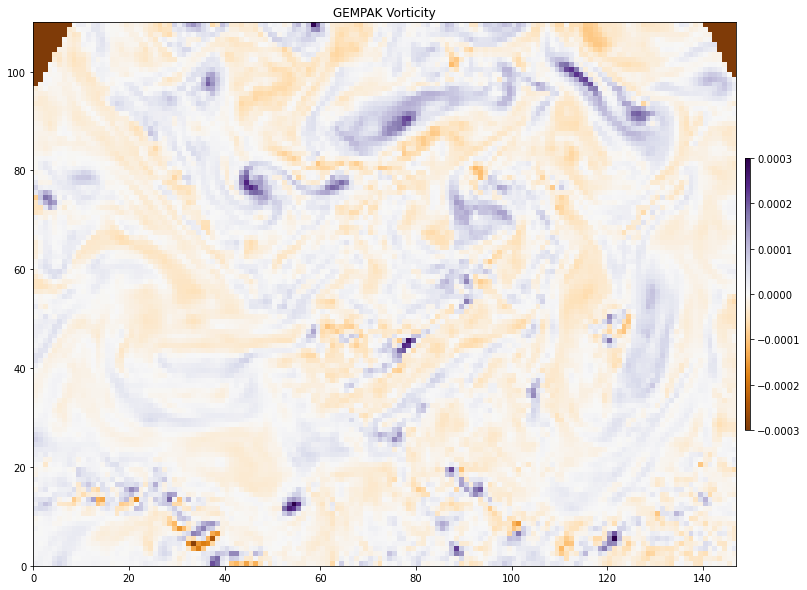

In [50]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(vor_gem, cmap=plt.cm.PuOr, vmin=-3e-4, vmax=3e-4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('GEMPAK Vorticity')
plt.show()

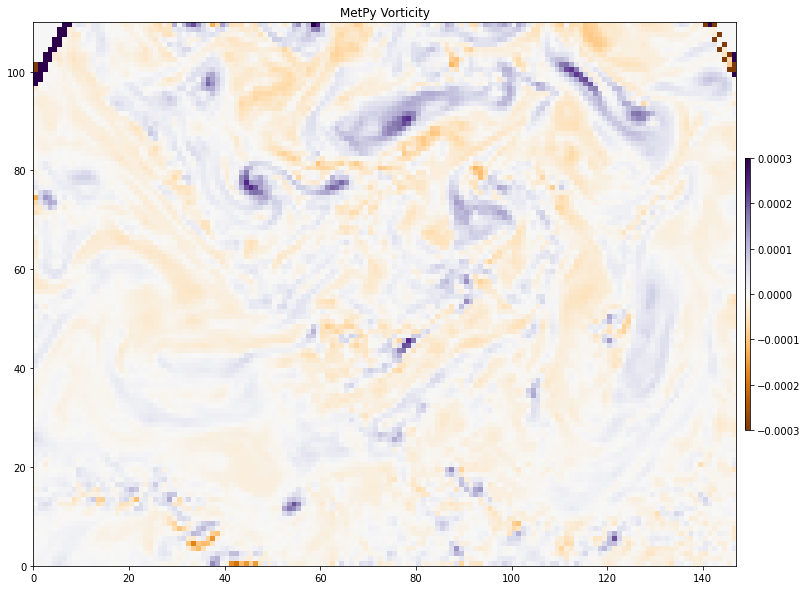

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(zeta, cmap=plt.cm.PuOr, vmin=-3e-4, vmax=3e-4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('MetPy Vorticity')
plt.show()

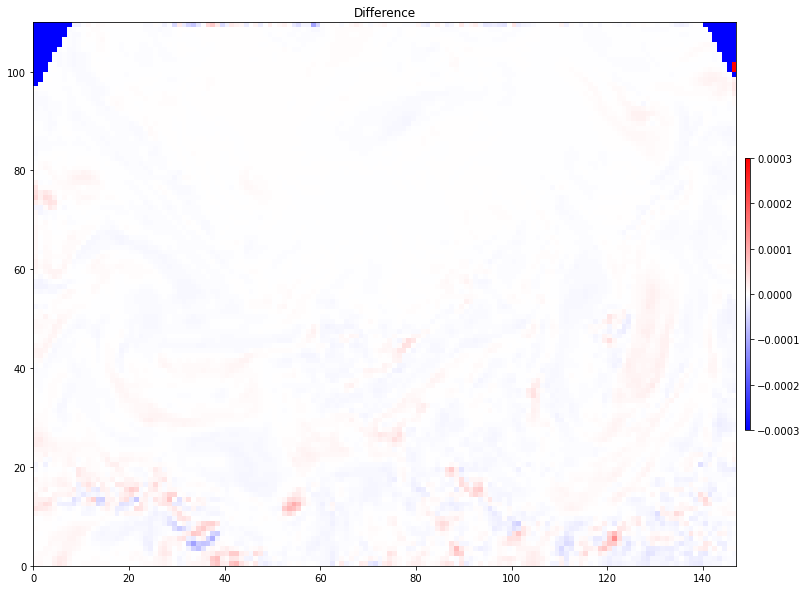

In [52]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(vor_gem - zeta.m, cmap=plt.cm.bwr, vmin=-3e-4, vmax=3e-4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('Difference')
plt.show()

### Reproduce GEMPAK calculation w/ GEMPAK values

In [53]:
dx = nominal_scale_gem
dy = nominal_scale_gem
m_x = msfx_gem
m_y = msfx_gem

dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)

# Calculating Vorticity using Map Factors
zeta = (m_x * dvdx - m_y * dudy
        - v * (m_x/m_y) * mpcalc.first_derivative(m_y, delta=dx, axis=-1)
        + u * (m_y/m_x) * mpcalc.first_derivative(m_x, delta=dy, axis=-2))

error_stats(zeta[6:-6,6:-6]*1e5, vor_gem[6:-6,6:-6]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): -0.0817388353803517
  Mean Values (GEMPAK): -0.08189264550264547

Max Comparison
  Max Values (MetPy): 30.08095988403535
  Max Values (GEMPAK): 30.137600000000003

Min Comparison
  Min Values (MetPy): -16.85640748852119
  Min Values (GEMPAK): -16.888099999999998

Difference Array
[-0.00354546 -0.00413055 -0.00508535 ... -0.00541975 -0.00250836
 -0.00011856]

Various Statistical Analyses
  Average Absolute Difference: 0.00463087008183296
  RMS Error: 5.7095829699642556e-05
  Standard Deviation of Difference: 0.00656546009136819
  Max Diff: 0.03169251147880914
  Min Diff: -0.05664011596465102
  Correlation: 0.9999999999646558
  Relative Magnitude Difference: 0.00015394688532830588



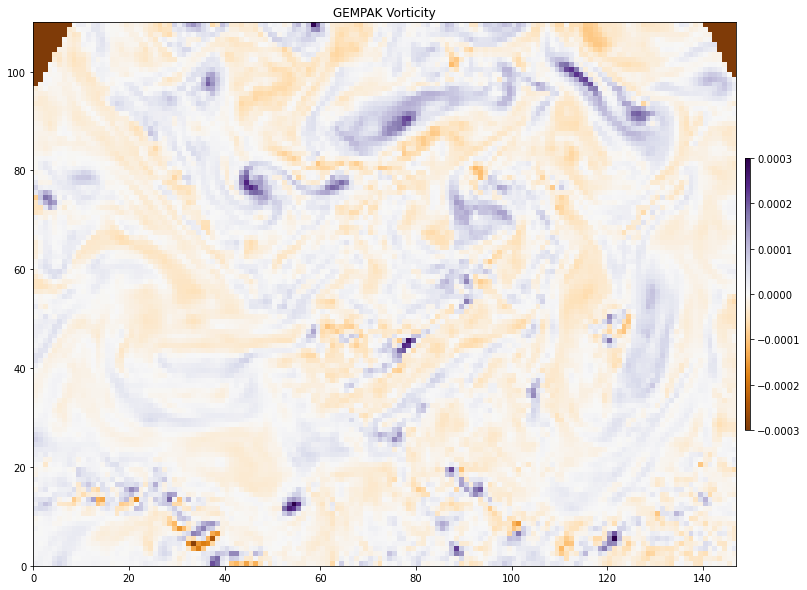

In [54]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(vor_gem, cmap=plt.cm.PuOr, vmin=-3e-4, vmax=3e-4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('GEMPAK Vorticity')
plt.show()

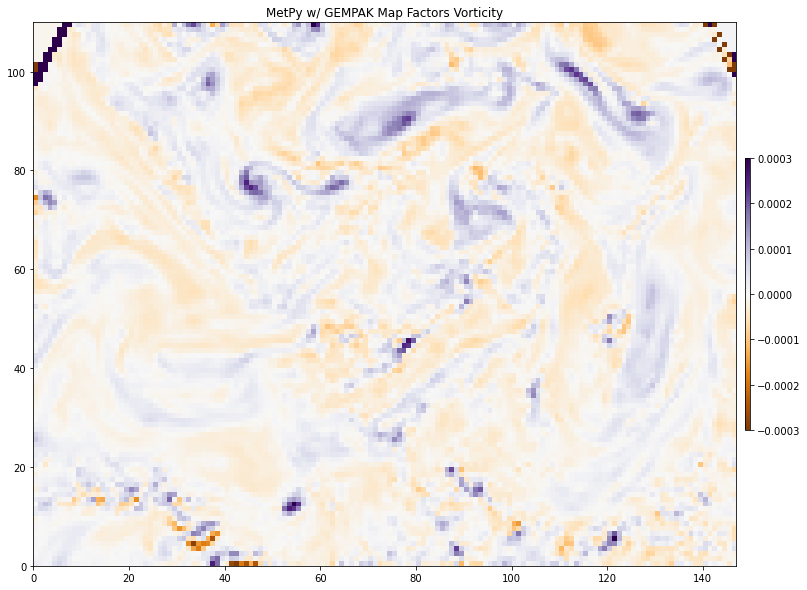

In [55]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(zeta, cmap=plt.cm.PuOr, vmin=-3e-4, vmax=3e-4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('MetPy w/ GEMPAK Map Factors Vorticity')
plt.show()

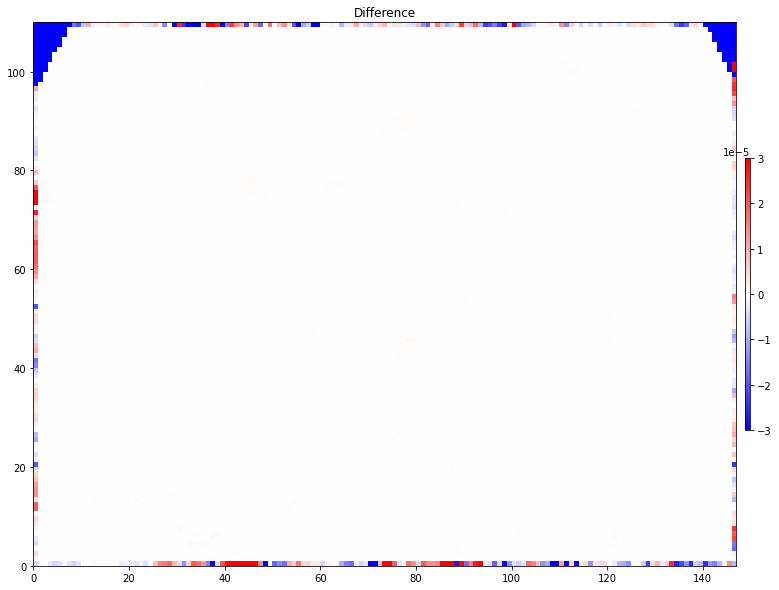

In [56]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(vor_gem - zeta.m, cmap=plt.cm.bwr, vmin=-3e-5, vmax=3e-5)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('Difference')
plt.show()

### Reproduce GEMPAK calculation with proj4 map factors

In [57]:
dx = nominal_scale_p4
dy = nominal_scale_p4
m_x = msfx_p4
m_y = msfx_p4

dudy = mpcalc.first_derivative(u, delta=dy, axis=-2)
dvdx = mpcalc.first_derivative(v, delta=dx, axis=-1)

# Calculating Vorticity using Map Factors
zeta = (m_x * dvdx - m_y * dudy
        - v * (m_x/m_y) * mpcalc.first_derivative(m_y, delta=dx, axis=-1)
        + u * (m_y/m_x) * mpcalc.first_derivative(m_x, delta=dy, axis=-2))

error_stats(zeta[6:-6,6:-6]*1e5, vor_gem[6:-6,6:-6]*1e5)

Is Xarray with Quantity? False
Is Metpy Unit Array? True

Mean Comparison
  Mean Values (MetPy): 0.055598150160359405
  Mean Values (GEMPAK): -0.08189264550264547

Max Comparison
  Max Values (MetPy): 32.84072299894286
  Max Values (GEMPAK): 30.137600000000003

Min Comparison
  Min Values (MetPy): -18.764226936699263
  Min Values (GEMPAK): -16.888099999999998

Difference Array
[-0.99712328 -1.14034422 -1.40808945 ... -0.82568784 -0.376887
  0.00577297]

Various Statistical Analyses
  Average Absolute Difference: 0.7486413863726958
  RMS Error: 0.010069793407329868
  Standard Deviation of Difference: 1.1500556776092004
  Max Diff: 10.61032299894286
  Min Diff: -13.504490896901135
  Correlation: 0.9456658947161833
  Relative Magnitude Difference: 0.0227961298658618



We see the correlation doesn't look so good, so we might have an issue with this kind of grid.

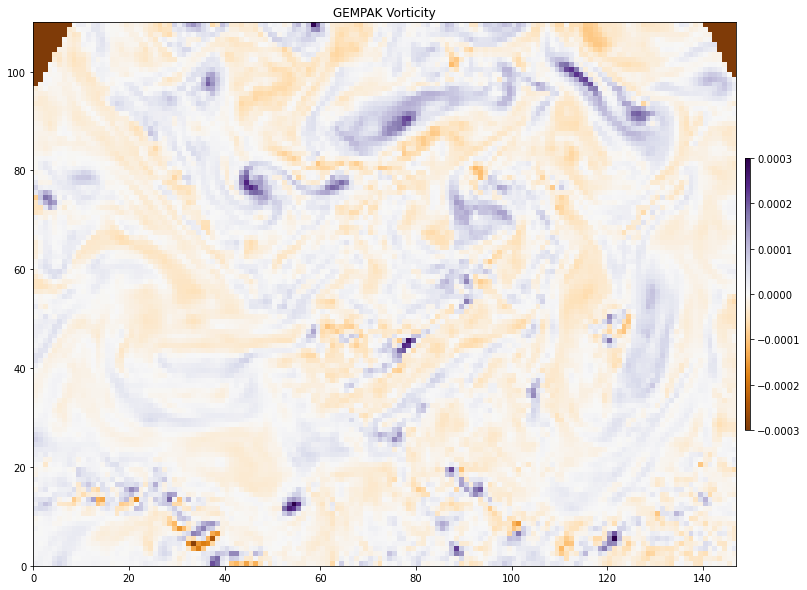

In [58]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(vor_gem, cmap=plt.cm.PuOr, vmin=-3e-4, vmax=3e-4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('GEMPAK Vorticity')
plt.show()

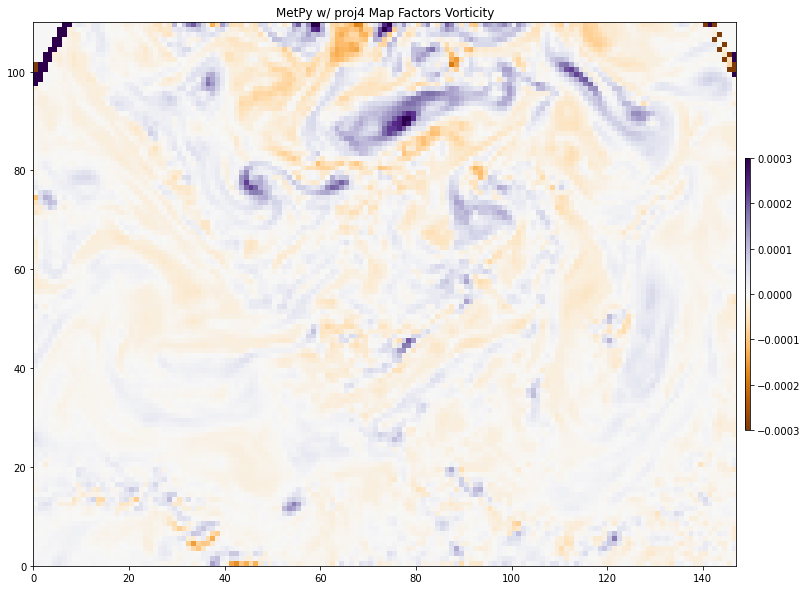

In [59]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(zeta, cmap=plt.cm.PuOr, vmin=-3e-4, vmax=3e-4)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('MetPy w/ proj4 Map Factors Vorticity')
plt.show()

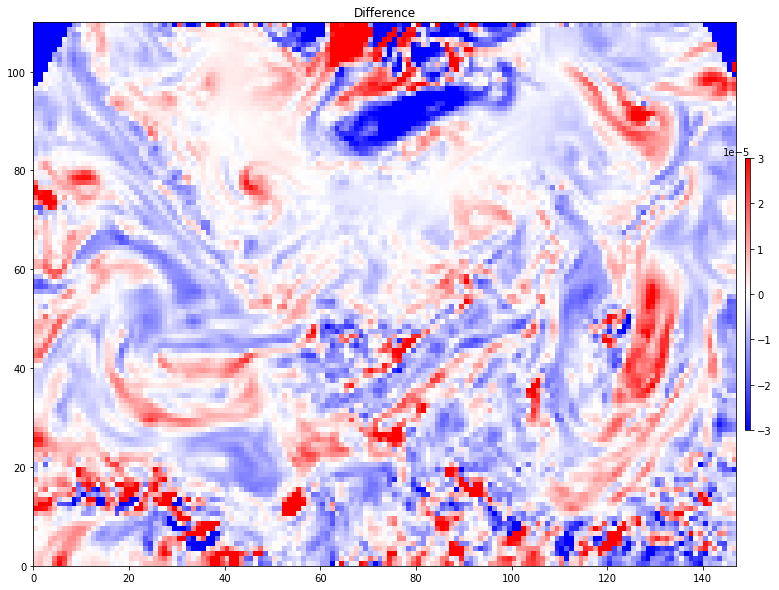

In [60]:
fig, ax = plt.subplots(figsize=(15,10))
cf = ax.pcolormesh(vor_gem - zeta.m, cmap=plt.cm.bwr, vmin=-3e-5, vmax=3e-5)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
plt.title('Difference')
plt.show()